In [26]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

(720, 1280, 3)


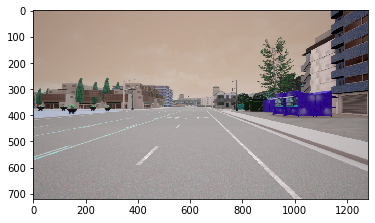

In [27]:
img = cv2.imread("test.jpg")
print(img.shape)
plt.imshow(img)
plt.show()

(720, 1280)


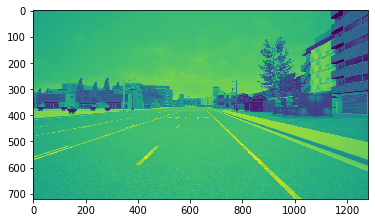

In [5]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray_img.shape)
plt.imshow(gray_img)
plt.show()

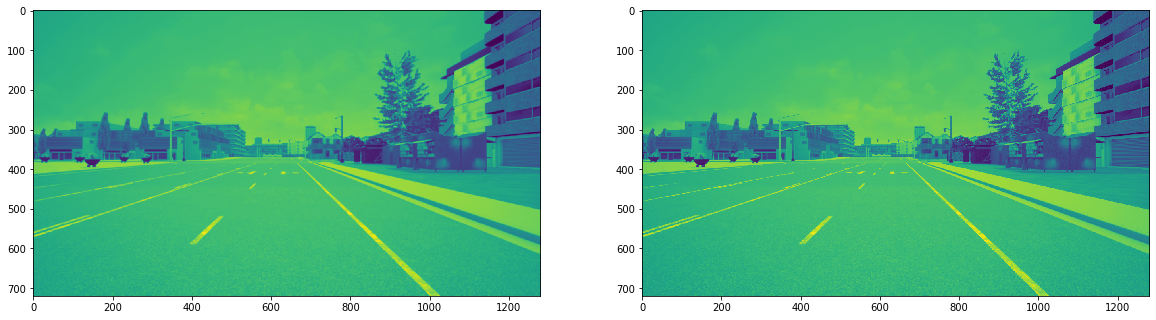

In [6]:
kernel_size = 3
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

blur_img = gaussian_blur(gray_img, kernel_size)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(blur_img)
plt.subplot(1,2,2)
plt.imshow(gray_img)
plt.show()

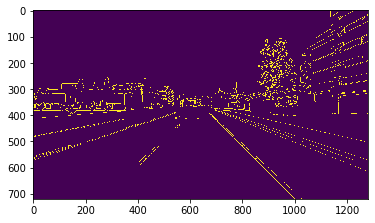

In [8]:
low_threshold = 60
high_threshold = 150
canny_img = cv2.Canny(blur_img, low_threshold, high_threshold)
plt.imshow(canny_img)
plt.show()

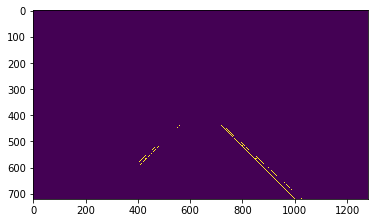

In [9]:
scale_w = 7 / 16
scale_h = 11 / 18
height, width, _= img.shape
left_bottom = [0, height - 1]
right_bottom = [width - 1, height - 1]
left_up = [scale_w * width, scale_h * height]
right_up = [(1 - scale_w) * width, scale_h * height]
vertices = np.array([[left_bottom, left_up, right_up, right_bottom]], dtype=np.int32)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

masked_edges = region_of_interest(canny_img, vertices)
plt.imshow(masked_edges)
plt.show()

err in regression prediction
outlierCleaner() is returning an empty list, no refitting to be done
err in regression prediction
outlierCleaner() is returning an empty list, no refitting to be done


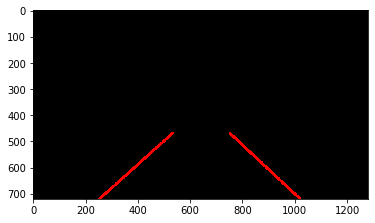

In [23]:
rho = 2  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 15  # minimum number of pixels making up a line
max_line_gap = 40  # maximum gap in pixels between connectable line segments
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

lines_img = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
# masked_edges = region_of_interest(canny_image, vertices)
plt.imshow(lines_img)
plt.show()

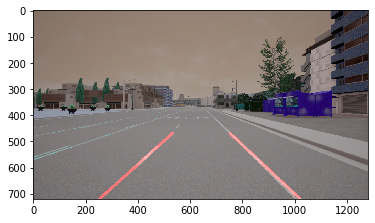

In [25]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

output = weighted_img(lines_img, img)
plt.imshow(output)
plt.show()

In [12]:
pre_l_slopes = []
pre_l_inters = []
pre_r_slopes = []
pre_r_inters = []
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    (1) remove some horizontal lines with given threshold_angle
    (2) seperate the points belongs to the left and right lane by computing line slope
    (3) handle the left/right lane points to a linear regressor to fit the line, with additional 
        steps to remove the outliers for getting a better fit.
    """
    threshold_angle = 25  # if the line angle is between -25 to 25 degrees, lines are discarded
    threshold_slope = math.tan(threshold_angle / 180 * math.pi)
    left_lane_x = []
    left_lane_y = []
    right_lane_x = []
    right_lane_y = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2 != x1:
                slope = float(y2 - y1) / float(x2 - x1)
                if abs(slope) < threshold_slope:  # remove the horizontal lines
                    continue
                elif slope < 0:  # left lane, note the origin is on the left-up corner of the image
                    left_lane_x.append([x1])
                    left_lane_y.append([y1])
                    left_lane_x.append([x2])
                    left_lane_y.append([y2])
                else:
                    right_lane_x.append([x1])
                    right_lane_y.append([y1])
                    right_lane_x.append([x2])
                    right_lane_y.append([y2])

    # get left and right solid lanes with regression
    if len(left_lane_x) > 0:  # if there are no enough points at the current frame
        regress_a_lane(img, left_lane_x, left_lane_y)
    if len(right_lane_x) > 0:
        regress_a_lane(img, right_lane_x, right_lane_y)

In [13]:
def regress_a_lane(img, x, y, color=[255, 0, 0], thickness=10):

    reg = LinearRegression()
    reg.fit(x, y)

    # identify and remove outliers
    cleaned_data = []
    try:
        predictions = reg.predict(x)
        cleaned_data = outlierCleaner(predictions, x, y)
    except NameError:
        print("err in regression prediction")

    if len(cleaned_data) > 0:
        x, y = cleaned_data   
        # refit cleaned data!
        try:
            reg.fit(x, y)
        except NameError:
            print("err in reg.fit for cleaned data")
    else:
        print("outlierCleaner() is returning an empty list, no refitting to be done")

    height = img.shape[0]
    slope = reg.coef_
    inter = reg.intercept_

    # find the two end points of the line by using slope and iter, and then visulize the line
    if reg.coef_ < 0:  # left lane
        p1_x, p1_y, p2_x, p2_y = findTwoPoints(slope, inter, 'l', height)
        cv2.line(img, (p1_x, p1_y), (p2_x, p2_y), color, thickness)
    else:  # right lane
        p1_x, p1_y, p2_x, p2_y = findTwoPoints(slope, inter, 'r', height)
        cv2.line(img, (p1_x, p1_y), (p2_x, p2_y), color, thickness)



In [14]:
def findTwoPoints(slope, inter, side, height):
    """
    In order to get two stable lanes,
    (1) average the slope and itercept values in the buffers, 
    (2) fix the y coordinate of the top points
    (3) then use the averaged slope and inter to locate the two end points of a line

    :param slope: current slope from the regressor for current frame
    :param inter: current intercept from the regressor for current frame
    :param side:  'l': left, 'r': right lane
    :param height: hight of the image
    :return tow points locations, which are the two ends of a lane
    """
    number_buffer_frames = 3
    scale_y = 0.65
    top_y = int(float(height) * scale_y)  # fix the y coordinates of the top point, so that the line is more stable
    

    if side == 'l':
        if len(pre_l_slopes) == number_buffer_frames:  # reach the max
            pre_l_slopes.pop(0)  # remove the oldest frame
            pre_l_inters.pop(0)

        pre_l_slopes.append(slope)
        pre_l_inters.append(inter)
        slope = sum(pre_l_slopes) / len(pre_l_slopes)
        inter = sum(pre_l_inters) / len(pre_l_inters)

        p1_y = height-1
        p1_x = int((float(p1_y)-inter)/slope)
        p2_y = top_y
        p2_x = int((float(p2_y)-inter)/slope)
    else:  # 'r'
        if len(pre_r_slopes) == number_buffer_frames:  # reach the max
            pre_r_slopes.pop(0)  # remove the oldest frame
            pre_r_inters.pop(0)

        pre_r_slopes.append(slope)
        pre_r_inters.append(inter)
        slope = sum(pre_r_slopes) / len(pre_r_slopes)
        inter = sum(pre_r_inters) / len(pre_r_inters)

        p1_y = top_y
        p1_x = int((float(p1_y)-inter)/slope)
        p2_y = height-1
        p2_x = int((float(p2_y)-inter)/slope)

    return (p1_x, p1_y, p2_x, p2_y)